In [82]:
# Import the needed libraries
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

from scipy.stats import halfnorm

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import the data

In [2]:
# Import two datasets containing the required data
df = pd.read_csv("./Data/titles.csv")
df2 = pd.read_csv("./Data/credits.csv")

In [3]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [4]:
df2.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [28]:
# Merge the two datasets
df_netflix = pd.merge(df, df2[df2["role"] == "DIRECTOR"], on=["id"])
df_netflix.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,3308,Martin Scorsese,NaN,DIRECTOR
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,17727,John Boorman,NaN,DIRECTOR
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11475,Terry Jones,NaN,DIRECTOR
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11473,Terry Gilliam,NaN,DIRECTOR
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1063,Robert Aldrich,NaN,DIRECTOR


In [29]:
# Drop unwanted features and rename 'name' into 'director'
df_netflix.drop(["person_id", 'role', 'character'], inplace=True, axis=1)
df_netflix.rename(columns={'name': 'director'}, inplace=True)

In [30]:
# Check for null values  in the data
df_netflix.info()

# Just 'seasons' contain a considerable amount of null values, but it is fine as films do not have information on the season, 
# and tv shows of 1 season also do not have info on the seasons number.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4550 non-null   object 
 1   title                 4549 non-null   object 
 2   type                  4550 non-null   object 
 3   description           4546 non-null   object 
 4   release_year          4550 non-null   int64  
 5   age_certification     2006 non-null   object 
 6   runtime               4550 non-null   int64  
 7   genres                4550 non-null   object 
 8   production_countries  4550 non-null   object 
 9   seasons               679 non-null    float64
 10  imdb_id               4222 non-null   object 
 11  imdb_score            4167 non-null   float64
 12  imdb_votes            4148 non-null   float64
 13  tmdb_popularity       4549 non-null   float64
 14  tmdb_score            4419 non-null   float64
 15  director             

In [31]:
netflix = df_netflix

# drop unused features
netflix.drop(['imdb_id', 'id', 'description'], axis=1, inplace=True)

print(netflix.shape)
netflix.head()

(4550, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [32]:
# Drop rows with no title
netflix.dropna(subset=['title', 'director', 'imdb_score', 'tmdb_score'], inplace=True)

print(netflix.shape)
netflix.head()

(4079, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


# Hypothesis testing

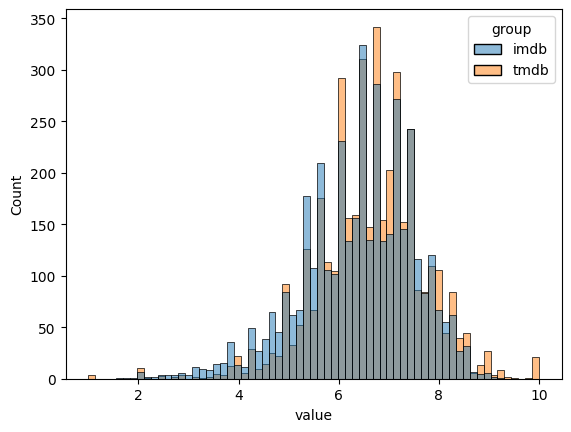

In [38]:
# Check the distribution of the two scores, from imdb and from tmbdb
y  = pd.DataFrame(dict(value=np.r_[netflix['imdb_score'], netflix['tmdb_score']], 
                       group=np.r_[['imdb']*len(netflix['imdb_score']), ['tmdb']*len(netflix['tmdb_score'])]))

sns.histplot(data=y, x="value", hue="group");

### Research question

Possible question 1: is the hypothesis of equal means of the two populations plausible?

Possible question 2:

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}

In [56]:
# Compute the mean score and standard deviation for imdb and tmdb
netflix_describe = netflix.describe()

# Mean scores
print("imdb mean score:", netflix_describe['imdb_score'].loc['mean'])
print("tmdb mean score:", netflix_describe['tmdb_score'].loc['mean'])
scores_mean = (netflix_describe['imdb_score'].loc['mean'] + netflix_describe['tmdb_score'].loc['mean'])/2
print('mean score:', scores_mean)

# Standard deviations
print("\nimdb std:", netflix_describe['imdb_score'].loc['std'])
print("tmdb std:", netflix_describe['tmdb_score'].loc['std'])
std_mean = (netflix_describe['imdb_score'].loc['std'] + netflix_describe['tmdb_score'].loc['std'])/2
print('mean std:', std_mean)

imdb mean score: 6.389899485167934
tmdb mean score: 6.622134346653592
mean score: 6.506016915910763

imdb std: 1.133238063593037
tmdb std: 1.0673718042503235
mean std: 1.1003049339216804


### Background information to set the prior

* The mean of the scores is about 6.5.
* The score of movies and tv shows follow a normal distribution, its mean can be assumed to be in (4.5, 8.5).
* Extreme values for the score are 1 (very poorly-made film) and 10 (masterpiece film). A plausible value for the standard deviation in the population is thus (6.5-1)/2 = 2.75.

### Prior for $\mu_{\text{imdb}}$ and $\mu_{\text{tmdb}}$

* The mean score of the population lies in (4.5, 8.5);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{imdb}}   \sim  N (6.5, 1.375)
$$
$$
\mu_{\text{tmdb}}   \sim  N (6.5, 1.375)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

In [79]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 2.5.

# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=4.1, size=10000)).describe()

,0
count,10000.000000
mean,3.257171
std,2.458809
min,0.000164
25%,1.306350
50%,2.746723
75%,4.655848
max,16.595529


### Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{imdb} \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}})$$

$$\vec{y}_{tmdb} \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})$$

where we use the vector notation to make it clear that these are array of measures.

###  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{drug}}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{placebo}}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\end{align*}


### Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [84]:
with pm.Model() as normal_model:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu = 6.5, sd = 1.375)
    mu_tmdb = pm.Normal('mu_tmdb', mu = 6.5, sd = 1.375)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)

    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed=netflix_describe['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed=netflix_describe['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [85]:
with normal_model:
    normal_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\manue\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\manue\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\manue\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 192 seconds.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


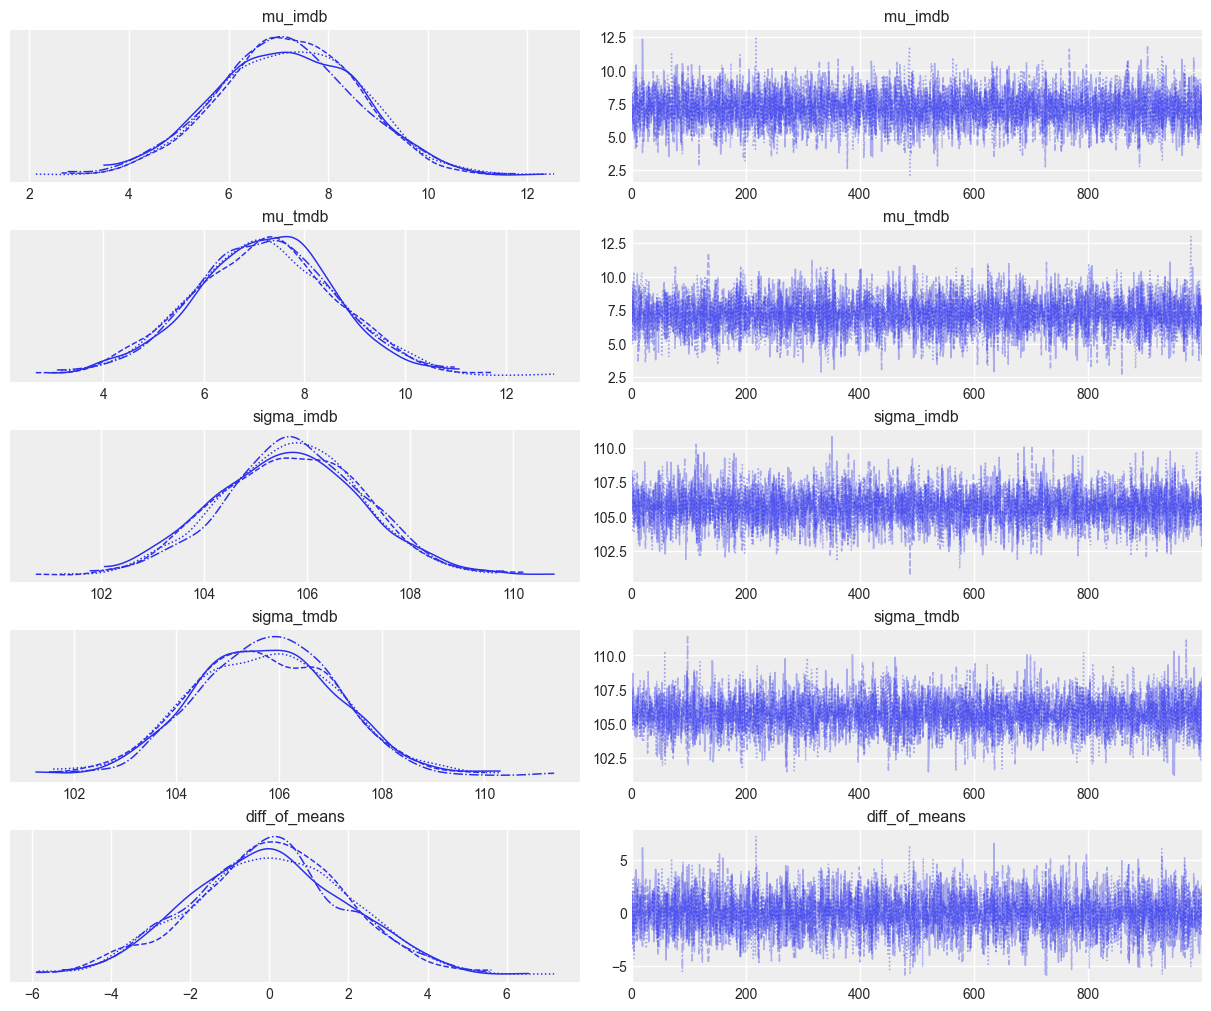

In [87]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(normal_trace);

In [88]:
# The posterior distribution can be checked in different ways, depending on the question we want to answer.

#Possible question 1: is the hypothesis of equal means of the two populations plausible?
#In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
#Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 
az.summary(normal_trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,7.187,1.399,4.552,9.973,0.016,0.012,7328.0,3201.0,1.0
mu_tmdb,7.187,1.388,4.371,9.846,0.018,0.013,6170.0,2933.0,1.0
sigma_imdb,105.684,1.366,102.975,108.262,0.017,0.012,6153.0,3016.0,1.0
sigma_tmdb,105.732,1.378,103.161,108.426,0.017,0.012,6246.0,3000.0,1.0
diff_of_means,-0.000,1.958,-3.759,3.847,0.024,0.031,6477.0,3319.0,1.0


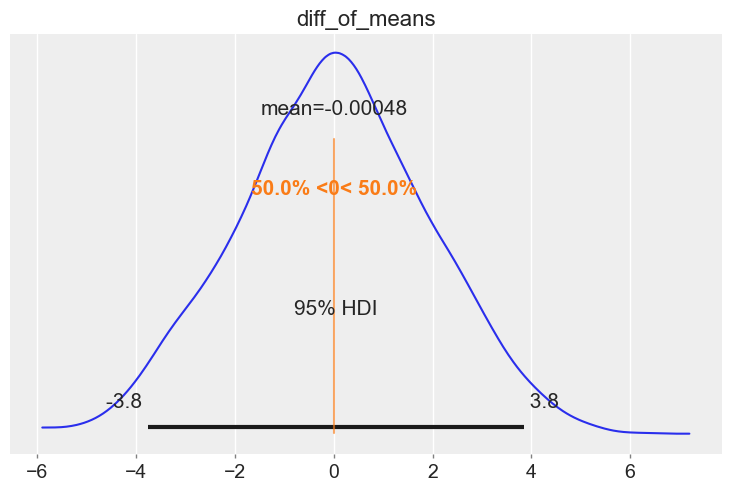

In [90]:
# Possible question 2: which is the posterior probability of an higher score in tmdb scoreboard?

#There is a probability >95% of tmdb giving an higher score than imdb; thus we accept the hypothesis oftmdb giving higher scores.
az.plot_posterior(normal_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);